# Data analysis of the HHBLITS and MMSeqs datasets

First of all, the sequence lengths of the datasets are inspected, since the ESM1b embeddings works with residue sequences that are below 1024 and 500.

**Loading of libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Loading dataset(s)

In [5]:
hhblits = np.load('/home/eryk/development/NSPThesis/data/nsp2/training_data/Train_HHblits.npz')['data']

## Sequence length distribution

Count the sequences and then plot the distribution as a histogram

In [3]:
def count_sequences(data):
    """Counts the sequences in given data"""
    hist = {}
    for seq in data:
        idx = sum(seq)
        hist[idx] = hist.get(idx, 0) + 1
    return hist

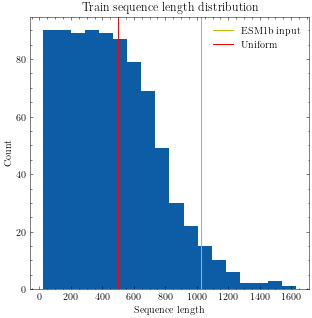

In [14]:
# Plot hhblits
plt.style.use('science')

hhblits_count = count_sequences(hhblits[:, :, 50])

plt.rcParams["figure.figsize"]=(5, 5)
n, bins, patches = plt.hist(x=hhblits_count, bins='auto')
plt.xlabel('Sequence length')
plt.ylabel('Count')
plt.title('Train sequence length distribution')
plt.axvline(x=1024, label='ESM1b input', c='y')
plt.axvline(x=500, label='Uniform', c='r')
plt.legend(loc='upper right')
plt.show()

**How many sequences are removed if lengths are reduced to only keep below 1024 and 600?**

In [15]:
total = sum(hhblits_count.values())

# lamda filter that filters out the keys
filter_total = lambda x, y: dict([ (i,x[i]) for i in x if i < y ])

# count if the sequences are reduced
reduce_1024 = sum(filter_total(hhblits_count, 1024).values())
reduce_500 = sum(filter_total(hhblits_count, 500).values())

print("total:", total)
print("<1024:", total-reduce_1024)
print("<500:", total-reduce_500)

total: 10848
<1024: 34
<500: 782


In [13]:
hhblits = hhblits[np.sum(hhblits[:, :, 50], axis=1) < 500]

In [14]:
hhblits.shape

(10066, 1632, 68)

In [15]:
np.savez_compressed("/home/eryk/development/NSPThesis/data/nsp2/training_data/Train_HHblits_500.npz", data=hhblits[:, :500, :])
np.savez_compressed("/home/eryk/development/NSPThesis/data/nsp2/training_data/Train_HHblits_500_small.npz", data=hhblits[:1000, :500, :])

## Split embedding dataset

In [1]:
import h5py
import pdb
import numpy as np

In [2]:
f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b.hdf5", "r")["dataset"]
f_sequences, f_residues, f_classes = f.shape

**Lets create a dataset where we reduce to only include below 500 residues**

In [10]:
batch = 250
max_residues = 500

with h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_500.hdf5", "w") as f2:
    dataset = f2.create_dataset("dataset", (1, max_residues, f_classes), maxshape=(None, max_residues, f_classes), dtype='float64', compression="gzip")
        
    n = 0
    for sequences in range(0, f_sequences, batch):
        
        # retrieve and filter sequences
        data = f[sequences:sequences+batch]
        data = data[np.sum(data[:, :, 50], axis=1) < max_residues]
        
        # expand dataset dimension
        data_sequences = data.shape[0]
        dataset.resize((n+data_sequences, max_residues, f_classes))
        
        # save the filtered data
        dataset[n:n+data_sequences] = data[:data_sequences, :max_residues]
        
        n += data_sequences

**Create small subsets**

In [12]:
f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b.hdf5", "r")["dataset"]

with h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_S.hdf5", "w") as f2:
    dataset = f2.create_dataset("dataset", (200, f.shape[1], f.shape[2]), dtype='float64', compression="gzip")
    dataset[:200] = f[:200]

f = h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_500.hdf5", "r")["dataset"]

with h5py.File("/home/eryk/development/NSPThesis/data/nsp3/training_data/Train_HHBlits_ESM1b_500_S.hdf5", "w") as f2:
    dataset = f2.create_dataset("dataset", (200, f.shape[1], f.shape[2]), dtype='float64', compression="gzip")
    dataset[:200] = f[:200]
    